# Test models and BLAST for evidence-based enzymes

In [11]:
from plants_sm.data_structures.dataset.single_input_dataset import SingleInputDataset

evidence_dataset = SingleInputDataset.from_csv('/scratch/jribeiro/ec_number_prediction/final_data/test_protein_evidence.csv',
                                            instances_ids_field="accession", representation_field="sequence", labels_field=slice(8, 2779))

In [12]:
y_true = evidence_dataset.y

In [16]:
def get_labels_to_remove(dataset, labels_names):
    labels_with_no_positive_sample = []
    for i, label in enumerate(labels_names):
        if dataset[label].sum() == 0:
            labels_with_no_positive_sample.append(i)
    return labels_with_no_positive_sample

In [17]:
import pandas as pd


dataset = pd.read_csv('/scratch/jribeiro/ec_number_prediction/final_data/test_protein_evidence.csv')
labels = evidence_dataset._labels_names
labels_to_remove = get_labels_to_remove(dataset, labels)
len(labels_to_remove)

1234

In [5]:
len(labels)

2771

In [13]:
import re


def get_ec_levels(labels):
    level_1 = []
    level_2 = []
    level_3 = []
    level_4 = []
    for i, label in enumerate(labels):
        if re.match(r"^\d+.\d+.\d+.n*\d+$", label):
            level_4.append(i)
        elif re.match(r"^\d+.\d+.\d+$", label):
            level_3.append(i)
        elif re.match(r"^\d+.\d+$", label):
            level_2.append(i)
        elif re.match(r"^\d+$", label):
            level_1.append(i)
    return level_1, level_2, level_3, level_4

In [18]:
y_true = evidence_dataset.y
level_1, level_2, level_3, level_4 = get_ec_levels(labels)

In [30]:
import numpy as np
y_true_ = np.delete(y_true, labels_to_remove, axis=1)
labels_ = np.delete(labels, labels_to_remove)
level_1, level_2, level_3, level_4 = get_ec_levels(labels_)

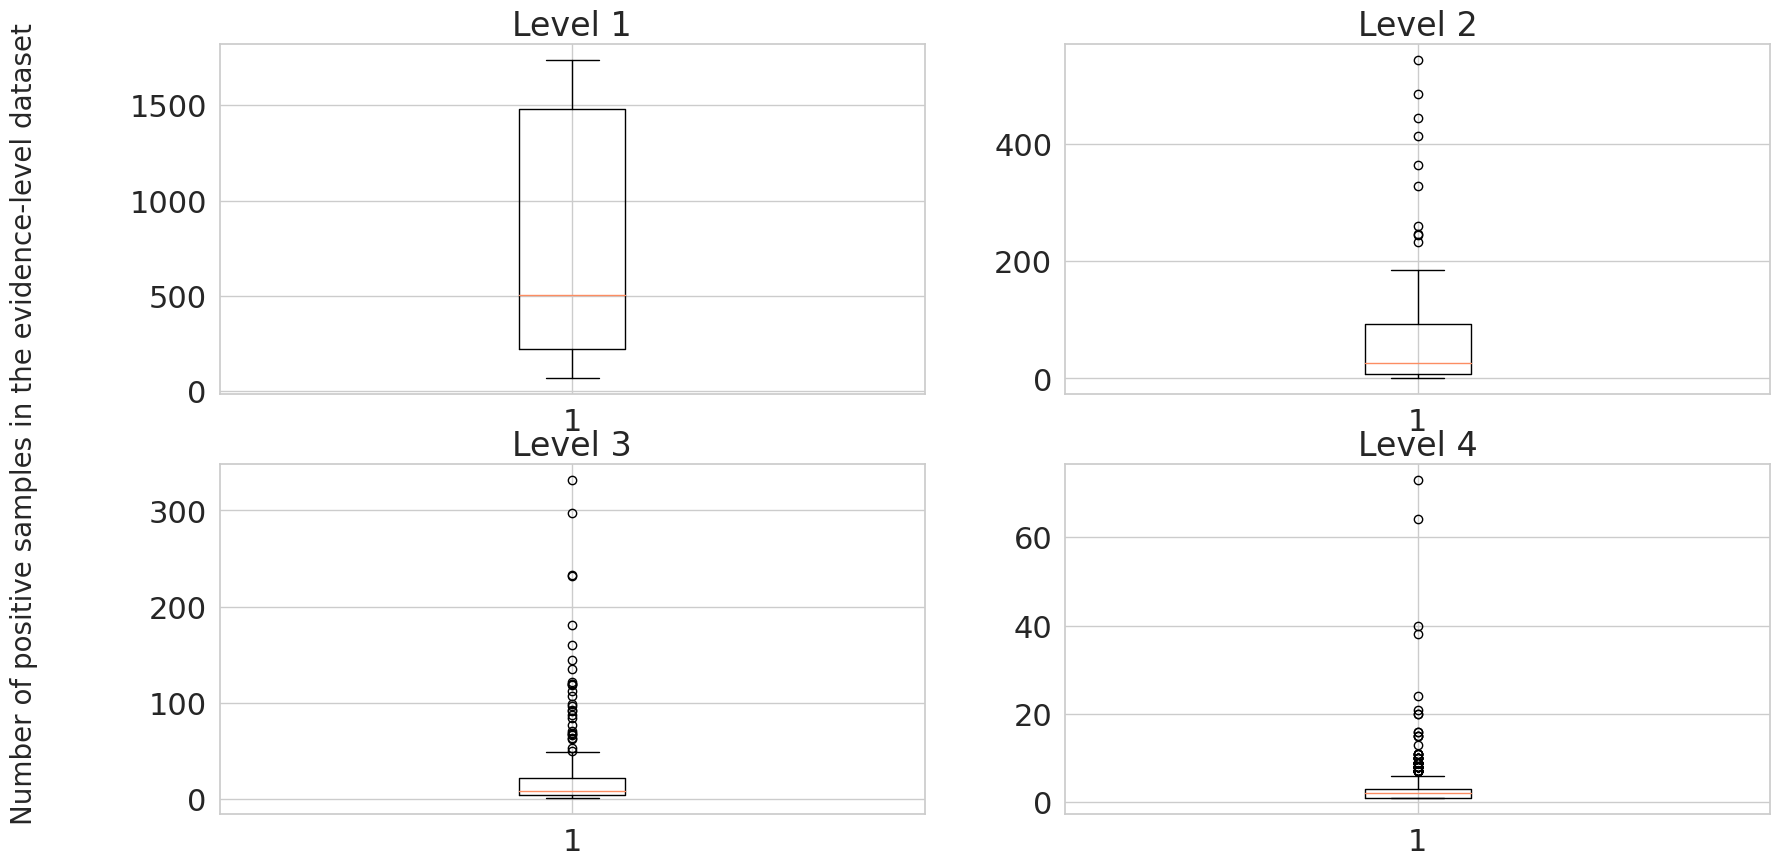

In [42]:
# get distribution of labels for level 4
import numpy as np

# remove all 0 values and create boxplot for level 4
y_true_level_4 = y_true_[:, level_4]
y_true_level_4 = y_true_level_4[y_true_level_4.sum(axis=1) != 0]
distribution_level4 = y_true_level_4.sum(axis=0)

y_true_level_3 = y_true_[:, level_3]
y_true_level_3 = y_true_level_3[y_true_level_3.sum(axis=1) != 0]
distribution_level3 = y_true_level_3.sum(axis=0)

y_true_level_2 = y_true_[:, level_2]
y_true_level_2 = y_true_level_2[y_true_level_2.sum(axis=1) != 0]
distribution_level2 = y_true_level_2.sum(axis=0)

y_true_level_1 = y_true_[:, level_1]
y_true_level_1 = y_true_level_1[y_true_level_1.sum(axis=1) != 0]
distribution_level1 = y_true_level_1.sum(axis=0)

# make 4 plots instead of only one
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.boxplot(distribution_level1)
fig.supylabel('Number of positive samples in the evidence-level dataset', fontsize=20)
# plt.ylabel('Number of positive samples in the evidence-level dataset')
plt.title('Level 1')
plt.subplot(2, 2, 2)
plt.boxplot(distribution_level2)
plt.title('Level 2')
plt.subplot(2, 2, 3)
plt.boxplot(distribution_level3)
plt.title('Level 3')
plt.subplot(2, 2, 4)
plt.boxplot(distribution_level4)
plt.title('Level 4')
plt.show()


In [6]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def get_metrics(y_true, predictions, labels, labels_to_remove, model_name):
    y_true_ = np.delete(y_true, labels_to_remove, axis=1)
    predictions_ = np.delete(predictions, labels_to_remove, axis=1)
    labels_ = np.delete(labels, labels_to_remove)
    level_1, level_2, level_3, level_4 = get_ec_levels(labels_)

    type_ = "weighted"
    
    metrics = {}
    metrics["wF1"] = f1_score(y_true_, predictions_, average=type_)
    metrics["wF1 level 1"] = f1_score(y_true_[:, level_1], predictions_[:, level_1], average=type_)
    metrics["wF1 level 2"] = f1_score(y_true_[:, level_2], predictions_[:, level_2], average=type_)
    metrics["wF1 level 3"] = f1_score(y_true_[:, level_3], predictions_[:, level_3], average=type_)
    metrics["wF1 level 4"] = f1_score(y_true_[:, level_4], predictions_[:, level_4], average=type_)

    metrics["wPrecision"] = precision_score(y_true_, predictions_, average=type_)
    metrics["wPrecision level 1"] = precision_score(y_true_[:, level_1], predictions_[:, level_1], average=type_)
    metrics["wPrecision level 2"] = precision_score(y_true_[:, level_2], predictions_[:, level_2], average=type_)
    metrics["wPrecision level 3"] = precision_score(y_true_[:, level_3], predictions_[:, level_3], average=type_)
    metrics["wPrecision level 4"] = precision_score(y_true_[:, level_4], predictions_[:, level_4], average=type_)

    metrics["wRecall"] = recall_score(y_true_, predictions_, average=type_)
    metrics["wRecall level 1"] = recall_score(y_true_[:, level_1], predictions_[:, level_1], average=type_)
    metrics["wRecall level 2"] = recall_score(y_true_[:, level_2], predictions_[:, level_2], average=type_)
    metrics["wRecall level 3"] = recall_score(y_true_[:, level_3], predictions_[:, level_3], average=type_)
    metrics["wRecall level 4"] = recall_score(y_true_[:, level_4], predictions_[:, level_4], average=type_)
    return pd.DataFrame(metrics, index=[model_name])

def get_models_predictions(model, dataset, labels, labels_to_remove, model_name):
    predictions = model.predict(dataset)
    y_true = dataset.y

    return get_metrics(y_true, predictions, labels, labels_to_remove, model_name)

# ESM2 layer 36

In [10]:
from plants_sm.models.pytorch_model import PyTorchModel

model = PyTorchModel.load("/scratch/jribeiro/results/esm2_t36_3B_UR50D/DNN_esm2_t36_3B_UR50D/DNN_esm2_t36_3B_UR50D_trial_2_merged")
evidence_dataset.load_features("/scratch/jribeiro/results/esm2_t36_3B_UR50D/test")

In [11]:
model.device = "cuda:0"

In [12]:
models_performance = get_models_predictions(model, evidence_dataset, labels, labels_to_remove, "DNN ESM2 3B")

/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ESM2 layer 33

In [13]:
from plants_sm.models.pytorch_model import PyTorchModel

model = PyTorchModel.load("/scratch/jribeiro/results/esm2_t33_650M_UR50D/DNN_esm2_t33_650M_UR50D/DNN_esm2_t33_650M_UR50D_trial_2_merged")
evidence_dataset.load_features("/scratch/jribeiro/results/esm2_t33_650M_UR50D/test")
model.device = "cuda:0"
models_performance = pd.concat((models_performance, get_models_predictions(model, evidence_dataset, labels, labels_to_remove, "DNN ESM2 650M")))

/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ESM1b layer 33

In [14]:
from plants_sm.models.pytorch_model import PyTorchModel

model = PyTorchModel.load("/scratch/jribeiro/results/esm1b_t33_650M_UR50S/DNN_esm1b_t33_650M_UR50S/DNN_esm1b_t33_650M_UR50S_trial_4_merged")
evidence_dataset.load_features("/scratch/jribeiro/results/esm1b_t33_650M_UR50S/test")
model.device = "cuda:0"
models_performance = pd.concat((models_performance, get_models_predictions(model, evidence_dataset, labels, labels_to_remove, "DNN ESM1b")))

/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ProteinBERT

In [15]:
from plants_sm.models.pytorch_model import PyTorchModel

model = PyTorchModel.load("/scratch/jribeiro/results/prot_bert_vectors/DNN_prot_bert_vectors/DNN_prot_bert_vectors_trial_2_merged")
evidence_dataset.load_features("/scratch/jribeiro/results/prot_bert_vectors/test")
model.device = "cuda:0"
models_performance = pd.concat((models_performance, get_models_predictions(model, evidence_dataset, labels, labels_to_remove, "DNN ProtBERT")))

/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
models_performance

,wF1,wF1 level 1,wF1 level 2,wF1 level 3,wF1 level 4,wPrecision,wPrecision level 1,wPrecision level 2,wPrecision level 3,wPrecision level 4,wRecall,wRecall level 1,wRecall level 2,wRecall level 3,wRecall level 4
DNN ESM2 t36 3B,0.932772,0.966549,0.944778,0.927986,0.861927,0.950606,0.976312,0.958428,0.946087,0.900357,0.922111,0.957198,0.933465,0.916148,0.852042
DNN ESM2 t33 650M,0.923730,0.963358,0.935528,0.918268,0.844223,0.947032,0.972601,0.956154,0.946141,0.888834,0.908806,0.954577,0.917683,0.898206,0.832073
DNN ESM1b t33 650M,0.929475,0.968590,0.942892,0.921726,0.851898,0.951350,0.978081,0.962598,0.947417,0.892575,0.915533,0.959469,0.925574,0.903332,0.842663
DNN ProtBERT,0.912279,0.952966,0.921799,0.902234,0.842353,0.945208,0.966366,0.955559,0.943125,0.894543,0.889371,0.940077,0.892396,0.871659,0.825719


# DeepEC

In [17]:
from plants_sm.models.pytorch_model import PyTorchModel

model = PyTorchModel.load("/scratch/jribeiro/results/one_hot_encoding/ABCMeta_one_hot_encoding/DeepEC_merged_merged")
evidence_dataset.load_features("/scratch/jribeiro/results/one_hot_encoding/test")
model.device = "cuda:0"
models_performance = pd.concat((models_performance, get_models_predictions(model, evidence_dataset, labels, labels_to_remove, "DeepEC CNN3")))

/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/env

# DSPACE

In [18]:
from plants_sm.models.pytorch_model import PyTorchModel

model = PyTorchModel.load("/scratch/jribeiro/results/one_hot_encoding/ABCMeta_one_hot_encoding/DSPACE_merged_merged")
evidence_dataset.load_features("/scratch/jribeiro/results/one_hot_encoding/test")
model.device = "cuda:0"
models_performance = pd.concat((models_performance, get_models_predictions(model, evidence_dataset, labels, labels_to_remove, "DSPACE EC")))

/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/env

# BLAST 

In [19]:
blast_predictions = pd.read_csv('../analysis_well_annotated_classes/test_blast_predictions_right_format.csv')

/tmp/ipykernel_2394585/1350985002.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  blast_predictions = pd.read_csv('../analysis_well_annotated_classes/test_blast_predictions_right_format.csv')


In [20]:
blast_predictions_evidence = blast_predictions[blast_predictions["qseqid"].isin(dataset["accession"])]

In [21]:
order_dict = {value: index for index, value in enumerate(evidence_dataset.dataframe["accession"])}

# Apply the custom sorting order using the map function
blast_predictions_evidence['Order'] = blast_predictions_evidence['qseqid'].map(order_dict)

# Sort the DataFrame based on the custom order
blast_predictions_evidence = blast_predictions_evidence.sort_values(by='Order')

# Drop the 'Order' column if it's not needed in the final output
blast_predictions_evidence.drop(columns=['Order'], inplace=True)
blast_predictions_evidence

/tmp/ipykernel_2394585/1360146106.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blast_predictions_evidence['Order'] = blast_predictions_evidence['qseqid'].map(order_dict)


,qseqid,EC,EC1,EC2,EC3,EC4,1,2,3,4,...,7.4.2.5,7.4.2.8,7.5.2.11,7.6.2.1,7.6.2.11,7.6.2.13,7.6.2.2,7.6.2.3,7.6.2.5,7.6.2.8
57463,Q59104,1.1.1.61,1,1.1,1.1.1,1.1.1.61,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32353,B9J8G8,5.1.1.8,5,5.1,5.1.1,5.1.1.8,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32388,B9JHU6,5.1.1.4,5,5.1,5.1.1,5.1.1.4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28279,B0VB44,5.1.1.8,5,5.1,5.1.1,5.1.1.8,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32396,B9JQV3,5.1.1.8,5,5.1,5.1.1,5.1.1.8,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39259,O89049,1.8.1.9;1.11.1.2,1,1.8;1.11,1.8.1;1.11.1,1.8.1.9;1.11.1.2,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42525,P32861,2.7.7.9,2,2.7,2.7.7,2.7.7.9,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51352,Q23652,2.7.7.52,2,2.7,2.7.7,2.7.7.52,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56449,Q4WED5,4.2.1.36,4,4.2,4.2.1,4.2.1.36,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
evidence_dataset.dataframe

,accession,name,EC,EC1,EC2,EC3,EC4,1,2,3,...,7.4.2.5,7.4.2.8,7.5.2.11,7.6.2.1,7.6.2.11,7.6.2.13,7.6.2.2,7.6.2.3,7.6.2.5,7.6.2.8
Q59104,Q59104,4HBDH_CUPNE,1.1.1.61,1,1.1,1.1.1,1.1.1.61,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B9J8G8,B9J8G8,4HPE1_AGRRK,5.1.1.8,5,5.1,5.1.1,5.1.1.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B9JHU6,B9JHU6,4HPE2_AGRRK,5.1.1.8,5,5.1,5.1.1,5.1.1.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0VB44,B0VB44,4HYPE_ACIBY,5.1.1.8,5,5.1,5.1.1,5.1.1.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B9JQV3,B9JQV3,4HYPE_AGRVS,5.1.1.8,5,5.1,5.1.1,5.1.1.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
O89049,O89049,TRXR1_RAT,1.8.1.9;1.11.1.2,1,1.8;1.11,1.8.1;1.11.1,1.8.1.9;1.11.1.2,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P32861,P32861,UGPA1_YEAST,2.7.7.9,2,2.7,2.7.7,2.7.7.9,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q23652,Q23652,USIP1_CAEEL,2.7.7.52,2,2.7,2.7.7,2.7.7.52,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q4WED5,Q4WED5,XANG_ASPFU,1.14.-.-,1,1.14,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
blast_predictions_evidence = blast_predictions_evidence.iloc[:, 6:].values

In [24]:
y_true = evidence_dataset.y
blast_prediction_metric = get_metrics(y_true, blast_predictions_evidence, labels, labels_to_remove, "BLASTp")

/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
models_performance = pd.concat((models_performance, blast_prediction_metric))

In [26]:
models_performance["model"] = models_performance.index

In [27]:
models_performance

,wF1,wF1 level 1,wF1 level 2,wF1 level 3,wF1 level 4,wPrecision,wPrecision level 1,wPrecision level 2,wPrecision level 3,wPrecision level 4,wRecall,wRecall level 1,wRecall level 2,wRecall level 3,wRecall level 4,model
DNN ESM2 t36 3B,0.932772,0.966549,0.944778,0.927986,0.861927,0.950606,0.976312,0.958428,0.946087,0.900357,0.922111,0.957198,0.933465,0.916148,0.852042,DNN ESM2 t36 3B
DNN ESM2 t33 650M,0.923730,0.963358,0.935528,0.918268,0.844223,0.947032,0.972601,0.956154,0.946141,0.888834,0.908806,0.954577,0.917683,0.898206,0.832073,DNN ESM2 t33 650M
DNN ESM1b t33 650M,0.929475,0.968590,0.942892,0.921726,0.851898,0.951350,0.978081,0.962598,0.947417,0.892575,0.915533,0.959469,0.925574,0.903332,0.842663,DNN ESM1b t33 650M
DNN ProtBERT,0.912279,0.952966,0.921799,0.902234,0.842353,0.945208,0.966366,0.955559,0.943125,0.894543,0.889371,0.940077,0.892396,0.871659,0.825719,DNN ProtBERT
DeepEC CNN3,0.714477,0.817549,0.718908,0.679165,0.586845,0.757268,0.823718,0.754643,0.733129,0.686501,0.697015,0.812893,0.695660,0.651593,0.573676,DeepEC CNN3
DSPACE EC,0.772156,0.854291,0.780322,0.751148,0.650844,0.843679,0.869284,0.841519,0.855679,0.783147,0.729805,0.840671,0.732963,0.684548,0.607262,DSPACE EC
BLASTp,0.937362,0.966874,0.948135,0.931148,0.878345,0.952275,0.978058,0.960959,0.945904,0.903496,0.928390,0.956150,0.936872,0.921091,0.878064,BLASTp


In [28]:
models_performance.to_csv("models_performance.csv", index=True)

In [7]:
import pandas as pd

models_performance = pd.read_csv("models_performance.csv", index_col=0)

# Ensemble 

In [8]:
# save predictions in pickle file
import pickle

with open("/scratch/jribeiro/ec_number_prediction/final_data/predictions_models_voting.pkl", "rb") as f:
    predictions_voting = pickle.load(f)

In [9]:
test = pd.read_csv("/scratch/jribeiro/ec_number_prediction/final_data/test.csv")

/tmp/ipykernel_2414242/3193923399.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("/scratch/jribeiro/ec_number_prediction/final_data/test.csv")


In [10]:
samples_to_include = test[test["accession"].isin(dataset["accession"])].index.values

In [11]:
predictions_voting_ = predictions_voting[samples_to_include, :]
predictions_voting_.shape

(5581, 2771)

In [12]:
voting_models_performance = get_metrics(evidence_dataset.y, predictions_voting_, labels, labels_to_remove, "Models ensemble")

/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
models_performance = pd.concat((models_performance, voting_models_performance))

In [14]:
# read predictions from pickle file
import pickle

with open("/scratch/jribeiro/ec_number_prediction/final_data/predictions_models_voting_blast.pkl", "rb") as f:
    voting_predictions_blast = pickle.load(f)

In [15]:
voting_predictions_blast_ = voting_predictions_blast[samples_to_include, :]
voting_predictions_blast_.shape

(5581, 2771)

In [16]:
voting_models_performance_blast = get_metrics(evidence_dataset.y, voting_predictions_blast_, labels, labels_to_remove, "Models + BLASTp ensemble")
voting_models_performance_blast

/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jribeiro/.conda/envs/plants_sm2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,wF1,wF1 level 1,wF1 level 2,wF1 level 3,wF1 level 4,wPrecision,wPrecision level 1,wPrecision level 2,wPrecision level 3,wPrecision level 4,wRecall,wRecall level 1,wRecall level 2,wRecall level 3,wRecall level 4
Models + BLASTp ensemble,0.940955,0.973341,0.951551,0.935787,0.875528,0.95263,0.977928,0.960253,0.94792,0.903739,0.935416,0.968903,0.944405,0.928781,0.873222


In [17]:
models_performance = pd.concat((models_performance, voting_models_performance_blast))

In [18]:
models_performance["model"] = models_performance.index
models_performance

,wF1,wF1 level 1,wF1 level 2,wF1 level 3,wF1 level 4,wPrecision,wPrecision level 1,wPrecision level 2,wPrecision level 3,wPrecision level 4,wRecall,wRecall level 1,wRecall level 2,wRecall level 3,wRecall level 4,model
DNN ESM2 t36 3B,0.932772,0.966549,0.944778,0.927986,0.861927,0.950606,0.976312,0.958428,0.946087,0.900357,0.922111,0.957198,0.933465,0.916148,0.852042,DNN ESM2 t36 3B
DNN ESM2 t33 650M,0.923730,0.963358,0.935528,0.918268,0.844223,0.947032,0.972601,0.956154,0.946141,0.888834,0.908806,0.954577,0.917683,0.898206,0.832073,DNN ESM2 t33 650M
DNN ESM1b t33 650M,0.929475,0.968590,0.942892,0.921726,0.851898,0.951350,0.978081,0.962598,0.947417,0.892575,0.915533,0.959469,0.925574,0.903332,0.842663,DNN ESM1b t33 650M
DNN ProtBERT,0.912279,0.952966,0.921799,0.902234,0.842353,0.945208,0.966366,0.955559,0.943125,0.894543,0.889371,0.940077,0.892396,0.871659,0.825719,DNN ProtBERT
DeepEC CNN3,0.714477,0.817549,0.718908,0.679165,0.586845,0.757268,0.823718,0.754643,0.733129,0.686501,0.697015,0.812893,0.695660,0.651593,0.573676,DeepEC CNN3
DSPACE EC,0.772156,0.854291,0.780322,0.751148,0.650844,0.843679,0.869284,0.841519,0.855679,0.783147,0.729805,0.840671,0.732963,0.684548,0.607262,DSPACE EC
BLASTp,0.937362,0.966874,0.948135,0.931148,0.878345,0.952275,0.978058,0.960959,0.945904,0.903496,0.928390,0.956150,0.936872,0.921091,0.878064,BLASTp
Models ensemble,0.933770,0.969541,0.945815,0.927886,0.861218,0.957053,0.980728,0.966337,0.954875,0.903984,0.918573,0.958770,0.927905,0.908458,0.849924,Models ensemble
Models + BLASTp ensemble,0.940955,0.973341,0.951551,0.935787,0.875528,0.952630,0.977928,0.960253,0.947920,0.903739,0.935416,0.968903,0.944405,0.928781,0.873222,Models + BLASTp ensemble


In [19]:
models_performance.to_csv("models_performance.csv", index=True)

In [2]:
color_map = {'DNN ESM2 35M': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'DNN ESM2 150M': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 'DNN ESM2 8M': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 'DNN ProtBERT': (0.8352941176470589, 0.3686274509803922, 0.0),
 'DNN ESM2 3B': (0.8, 0.47058823529411764, 0.7372549019607844),
 'DNN ESM2 650M': (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 'DNN ESM1b': (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 'DeepEC CNN3': (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 'DSPACE EC': (0.9254901960784314, 0.8823529411764706, 0.2),
 'Models + BLASTp ensemble': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'Models ensemble': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
    'BLASTp': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),}

<Figure size 1000x800 with 0 Axes>

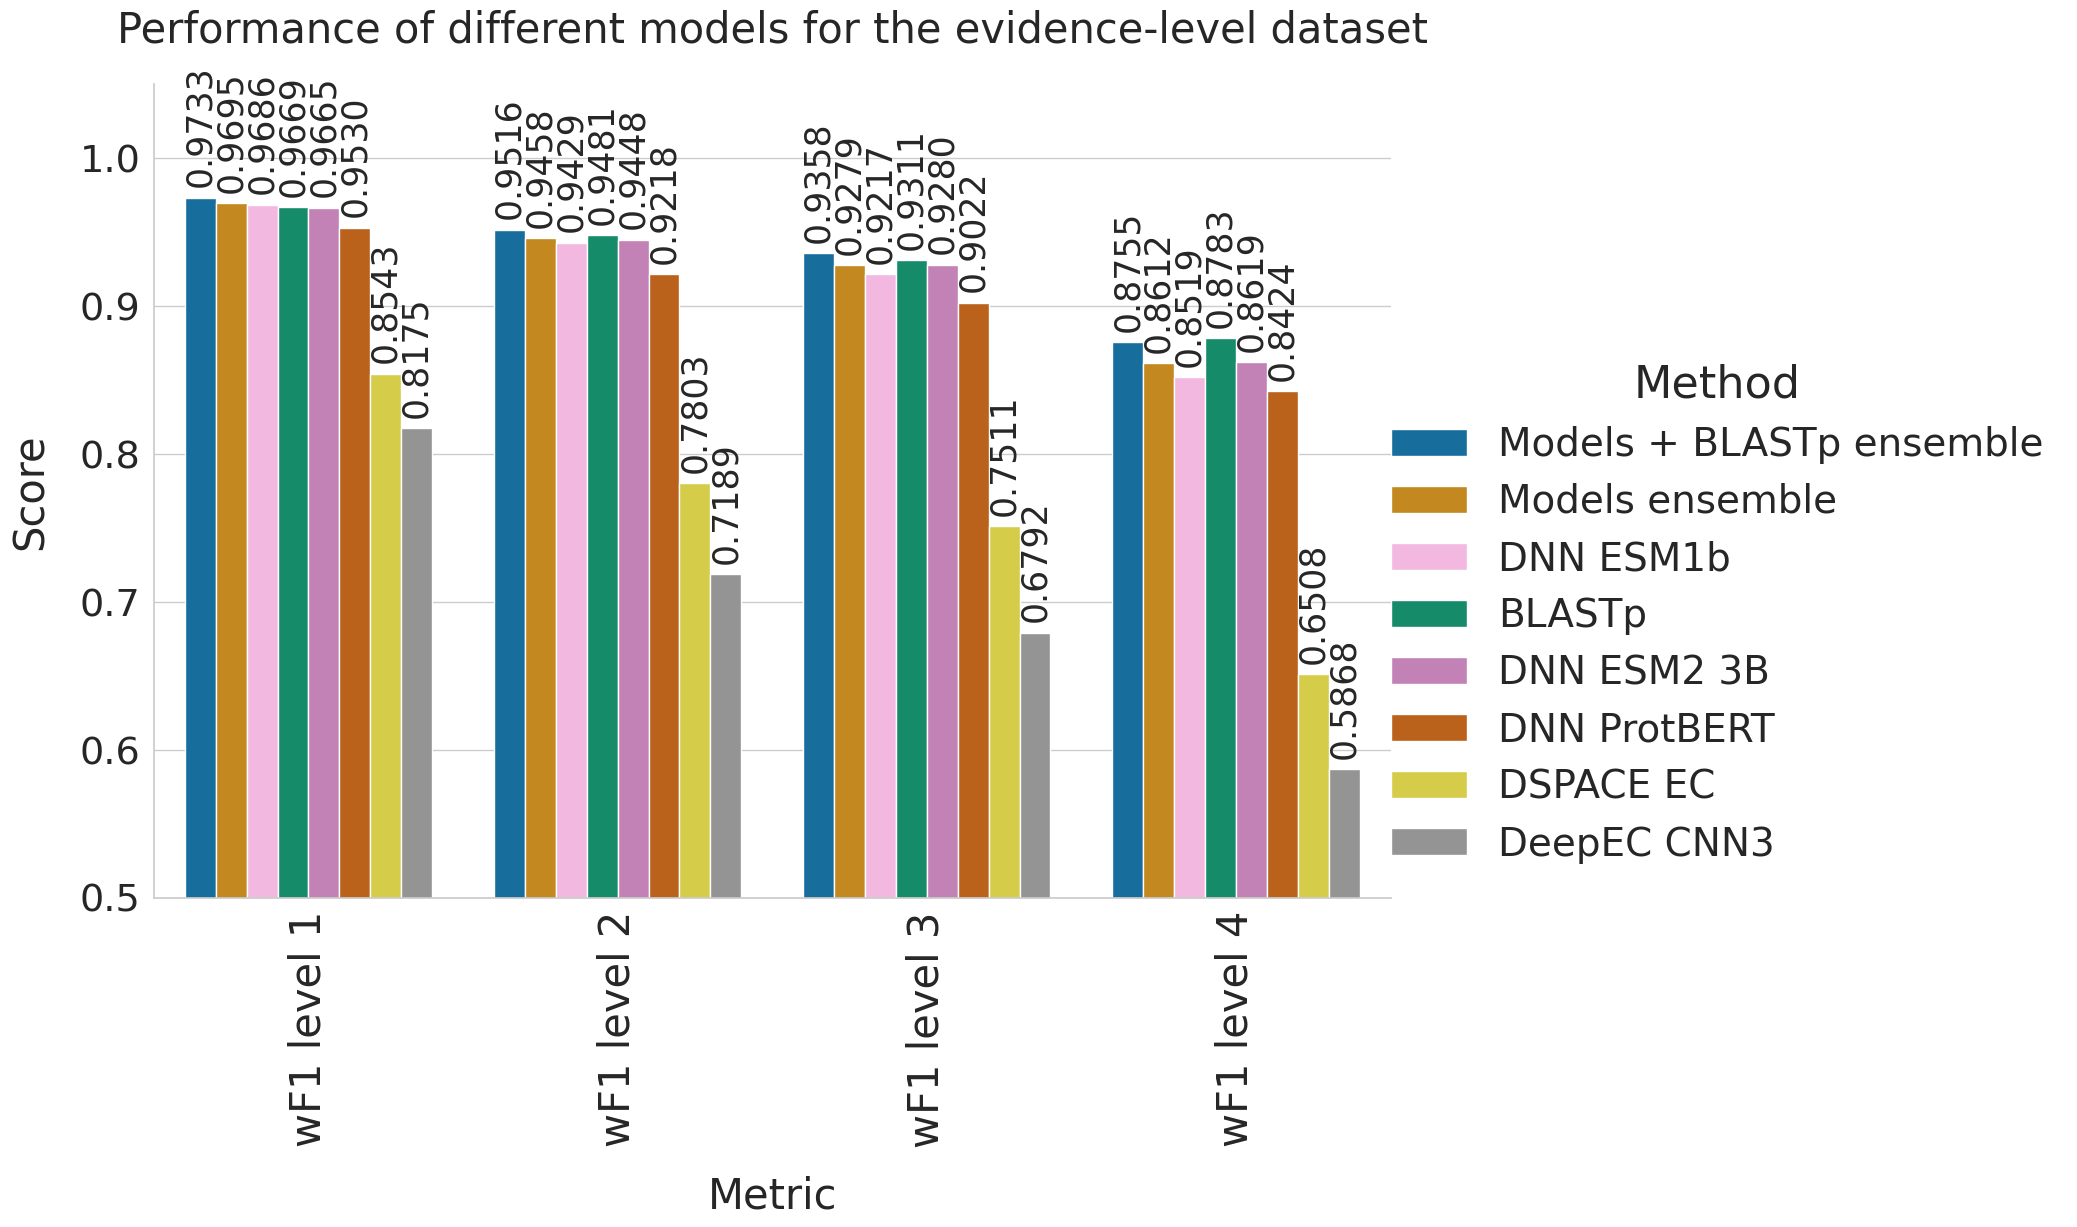

In [21]:
# create a bar plot of the f1 scores, precision and recall all in different plots

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib

matplotlib.rcParams['savefig.transparent'] = True

models_performance = pd.read_csv("models_performance.csv", index_col=0)
models_performance_ = models_performance.iloc[:, 1:5]
models_performance_["model"] = models_performance["model"]
# models_performance_ = models_performance.reset_index()
# models_performance_ = models_performance.rename(columns={"index": "model"})
models_performance_ = models_performance_.melt(id_vars=["model"], var_name="metric", value_name="score")
models_performance_ = models_performance_.sort_values(by=["metric","score"], ascending=[True, False])

plt.figure(figsize=(10, 8))
sns.set(rc={'figure.figsize':(10, 8)})
sns.set(font_scale=2.5)
sns.set_style("whitegrid")
sns.set_palette("Set2")


g = sns.catplot(x="metric", y="score", hue="model", data=models_performance_, kind="bar", height=10, aspect=1.5, palette=color_map)

for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height() +  0.04), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontsize=25,  # Adjust the fontsize here
                    rotation=90)

plt.title("Performance of different models for the evidence-level dataset", pad=30, fontsize=30)
plt.xlabel("Metric", labelpad=20, fontsize=30)
plt.ylabel("Score", labelpad=20, fontsize=30)


plt.setp(g.legend.get_texts(), fontsize='28') # for legend text
plt.setp(g.legend.get_title(), fontsize='32') 
g.legend.set_title("Method", prop = {'size':'32'})
g.set_xticklabels(rotation=90, fontsize=30)
g.set(ylim=(0.5, 1.05))
g.savefig("models_performance_evidence_level.png", bbox_inches='tight', dpi=400)